In [9]:
from ASML_REG_BASE import AutoStreamRegressorBase

In [10]:
import psutil
import time
import json

In [11]:
from capymoa.stream import stream_from_file
from capymoa.evaluation import RegressionEvaluator, RegressionWindowedEvaluator

In [12]:
from river import metrics

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
datasets = [
    'ailerons',
    'elevators',
    'fried',
    'hyperA',
    'FriedmanGsg',
    'FriedmanGra',
    'FriedmanLea',
    'kin8nm',
    'abalone',
    'bike',
    'House8L',
    'MetroTraffic',
    'cpu_activity',
    'white_wine',
]

In [15]:
dataset_name = 'House8L'

In [16]:
stream = stream_from_file(f"RDatasets/{dataset_name}.arff")

In [17]:
regressionEvaluator = RegressionEvaluator(schema=stream.get_schema())
regressionWindowedEvaluator = RegressionWindowedEvaluator(schema=stream.get_schema(),window_size=1000)

In [18]:
ASR = AutoStreamRegressor(config_dict=None, # config_dict
    exploration_window=1000, # Window Size
    prediction_mode="ensemble", #change 'best' or 'ensemble' if you want best model prediction 
    budget=10, # How many pipelines run concurrently
    ensemble_size=5, # Ensemble size 
    metric=metrics.RMSE(), # Online metrics
    feature_selection = True,
    aggregation_method='mean', #mean, median
    verbose=False,
    seed=42) # Random/Fixed seed

In [19]:
len(ASR.pipeline_list)

10

In [20]:
%%time
t=0
times = []
memories = []
#track_pipes = []
while stream.has_more_instances():
    instance = stream.next_instance()
    x = dict(enumerate(instance.x))
    mem_before = psutil.Process().memory_info().rss # Recording Memory
    start = time.time()  # Recording Time
    #print(f"true: {instance.y_value}")
    prediction = ASR.predict_one(x)
    #print(f"y_true: {instance.y_value}, y_pred: {prediction}")
    regressionEvaluator.update(instance.y_value, prediction)
    regressionWindowedEvaluator.update(instance.y_value, prediction)
    ASR.learn_one(x, instance.y_value)
    end = time.time()
    mem_after = psutil.Process().memory_info().rss
    iteration_mem = mem_after - mem_before
    memories.append(iteration_mem)
    iteration_time = end - start
    times.append(iteration_time)
    ASR.update_interpret_info(regressionEvaluator.metrics_dict(), ASR.best_model, y_pred=prediction,y_true=instance.y_value)
    t+=1
    print(f"Running Instance....{t}",end='\r')
    if t%1000==0:
        print(f"Running Instance **{t}**")
        print(f"R2 score - {round(regressionEvaluator.R2(),5)}")
        print(f"RMSE score - {round(regressionEvaluator.RMSE(),5)}")
        print("-"*40)

Running Instance **1000**
R2 score - 0.31154
RMSE score - 45728.8709
----------------------------------------
Running Instance **2000**
R2 score - 0.39142
RMSE score - 42640.03237
----------------------------------------
Running Instance **3000**
R2 score - 0.39079
RMSE score - 42879.81441
----------------------------------------
Running Instance **4000**
R2 score - 0.41877
RMSE score - 41441.28271
----------------------------------------
Running Instance **5000**
R2 score - 0.43607
RMSE score - 40994.05065
----------------------------------------
Running Instance **6000**
R2 score - 0.45205
RMSE score - 40395.38571
----------------------------------------
Running Instance **7000**
R2 score - 0.46047
RMSE score - 39699.35023
----------------------------------------
Running Instance **8000**
R2 score - 0.46125
RMSE score - 39240.46741
----------------------------------------
Running Instance **9000**
R2 score - 0.46555
RMSE score - 39027.19623
----------------------------------------
Ru

In [21]:
regressionEvaluator.metrics_dict()

{'classified instances': 22784.0,
 'mean absolute error': 18774.263616816173,
 'root mean squared error': 36925.76600480967,
 'relative mean absolute error': 0.5770462985001581,
 'relative root mean squared error': 0.6985527135734008,
 'coefficient of determination': 0.5120241063592383,
 'adjusted coefficient of determination': 0.5118312643884485}

In [22]:
regressionWindowedEvaluator.metrics_per_window()

,classified instances,mean absolute error,root mean squared error,relative mean absolute error,relative root mean squared error,coefficient of determination,adjusted coefficient of determination
0,1000.0,21766.111131,45728.870899,0.700935,0.831313,0.308919,0.302637
1,1000.0,20797.509469,39309.223948,0.602888,0.725505,0.473643,0.468858
2,1000.0,21934.707982,43355.400248,0.641944,0.781018,0.390011,0.384466
3,1000.0,19070.507671,36789.729528,0.578680,0.699389,0.510854,0.506408
4,1000.0,19408.609489,39154.071231,0.591147,0.704837,0.503205,0.498689
5,1000.0,18493.796798,37258.048471,0.555113,0.683731,0.532511,0.528261
6,1000.0,17783.475567,35235.574927,0.551519,0.693313,0.519317,0.514947
7,1000.0,18736.558056,35864.263574,0.606364,0.729422,0.467943,0.463106
8,1000.0,18163.158658,37277.126361,0.571607,0.706674,0.500612,0.496072
9,1000.0,18651.784895,39458.105131,0.576000,0.696882,0.514355,0.509940


In [23]:
ASR.new_pipeline_probability

0.4

In [25]:
ASR.current_score

RMSE: 46,807.584684

In [26]:
df = ASR.get_interpret_info()

In [56]:
import pandas as pd

In [57]:
df = pd.read_csv("House8L_Tarck.csv")

In [58]:
#df.to_csv(f"{dataset_name}_Tarck.csv")

In [59]:
df

,Unnamed: 0,instance,pipeline,pre_hyper,feature_hyper,model_hyper,mean absolute error,root mean squared error,relative mean absolute error,relative root mean squared error,coefficient of determination,adjusted coefficient of determination
0,0,1000,"('MinMaxScaler', 'AdaptiveRandomForestRegressor')",{},NaN,"{'n_models': 3, 'max_depth': 10, 'aggregation_...",21305.445958,44798.682297,0.681252,0.812858,0.339262,0.333256
1,1,2000,"('MinMaxScaler', 'AdaptiveRandomForestRegressor')",{},NaN,"{'n_models': 4, 'max_depth': 10, 'aggregation_...",20717.115587,41838.850694,0.634686,0.765457,0.414076,0.411426
2,2,3000,"('MinMaxScaler', 'AdaptiveRandomForestRegressor')",{},NaN,"{'n_models': 3, 'max_depth': 10, 'aggregation_...",20620.571873,41396.534810,0.622213,0.753517,0.432212,0.430503
3,3,4000,"('MinMaxScaler', 'AdaptiveRandomForestRegressor')",{},NaN,"{'n_models': 3, 'max_depth': 10, 'aggregation_...",20198.397381,40323.332351,0.611991,0.741821,0.449702,0.448461
4,4,5000,"('MinMaxScaler', 'AdaptiveRandomForestRegressor')",{},NaN,"{'n_models': 8, 'max_depth': 40, 'aggregation_...",19893.029937,39781.276831,0.602381,0.728736,0.468944,0.467987
5,5,6000,"('MinMaxScaler', 'AdaptiveRandomForestRegressor')",{},NaN,"{'n_models': 8, 'max_depth': 40, 'aggregation_...",19793.500129,39501.911429,0.598358,0.723864,0.476021,0.475234
6,6,7000,"('MinMaxScaler', 'AdaptiveRandomForestRegressor')",{},NaN,"{'n_models': 8, 'max_depth': 40, 'aggregation_...",19569.528632,38786.264280,0.592655,0.717634,0.485001,0.484338
7,7,8000,"('MinMaxScaler', 'SelectKBest', 'AdaptiveRando...",{},{'k': 10},"{'n_models': 3, 'max_depth': 10, 'aggregation_...",19437.868296,38355.804725,0.592498,0.717446,0.485271,0.484691
8,8,9000,"('MinMaxScaler', 'SelectKBest', 'AdaptiveRando...",{},{'k': 10},"{'n_models': 3, 'max_depth': 10, 'aggregation_...",19312.573372,38299.817841,0.589836,0.717433,0.485289,0.484774
9,9,10000,"('MinMaxScaler', 'SelectKBest', 'AdaptiveRando...",{},{'k': 10},"{'n_models': 3, 'max_depth': 10, 'aggregation_...",19209.695378,38333.445270,0.586838,0.713670,0.490675,0.490216


In [23]:
# saving results in dict
save_record = {
    "model": 'ASML_REG_PWHNS', #AB -  AUTO- BUDGET ADJUSTMENT #IPUL =  INCRSE PROBABILTY UPPER LOWER
    "dataset": dataset_name,
    "regressionEvaluator": regressionEvaluator.metrics_dict(),
    "windows_scores": regressionWindowedEvaluator.metrics_per_window().to_dict(orient='list'),
    "time": times,
    "memory": memories
}

In [24]:
file_name = f"{save_record['model']}_{save_record['dataset']}.json"

In [25]:
file_name

'ASML_REG_NProb_ailerons.json'

In [56]:
# To store the dictionary in a JSON file
with open(f"ABLATION_TEMP/{file_name}", 'w') as json_file:  # change temp to  saved_results_json for final run
    json.dump(save_record, json_file)

In [29]:
!pip show river

Name: river
Version: 0.10.1
Summary: Online machine learning in Python
Home-page: https://github.com/online-ml/river
Author: Max Halford
Author-email: maxhalford25@gmail.com
License: BSD-3
Location: /Users/nv78/opt/miniconda3/lib/python3.9/site-packages
Requires: numpy, pandas, scipy
Required-by: EvOAutoML


In [60]:
import ast

In [61]:
dp_track = df.instance.to_list()

In [62]:
dp_track

[1000,
 2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 9000,
 10000,
 11000,
 12000,
 13000,
 14000,
 15000,
 16000,
 17000,
 18000,
 19000,
 20000,
 21000,
 22000]

In [64]:
algo_track = []
for pipe, k in zip(df.pipeline.to_list(), df.feature_hyper.to_list()):
    pipe = ast.literal_eval(pipe)
    if pd.notna(k):
        pass
        k = ast.literal_eval(k)
    if len(pipe)==3:
        p,f,c = pipe
        if len(k)!=0:
            f+=f"(k={k['k']})"
        algo_track.append(
            " | ".join([p,f,c])
        )
    else:
        p,c = pipe
        algo_track.append(
            " | ".join([p,c])
        )

In [34]:
#algo_track = [" | ".join(pipe)for pipe, k in zip(df.pipeline.to_list(), df.feature_hyper.to_list())]

In [65]:
set(algo_track)

{'MaxAbsScaler | SelectKBest(k=10) | AdaptiveRandomForestRegressor',
 'MaxAbsScaler | SelectKBest(k=7) | AdaptiveRandomForestRegressor',
 'MinMaxScaler | AdaptiveRandomForestRegressor',
 'MinMaxScaler | KNNRegressor',
 'MinMaxScaler | SelectKBest(k=10) | AdaptiveRandomForestRegressor'}

In [66]:
score_track =  df['root mean squared error'].to_list()

In [67]:
file_name = 'asml_pipe_track_' + dataset_name

In [68]:
file_name

'asml_pipe_track_House8L'

In [69]:
[val for i, val in enumerate(dp_track) if i%1000==0]

[1000]

In [70]:
#plt.rcParams["font.family"] = "Times New Roman"

In [71]:
from matplotlib import rcParams

In [72]:
# Set the font to Times New Roman
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

In [73]:
rcParams['font.weight'] = 'bold'
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelweight'] = 'bold'

In [74]:
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 18
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 18

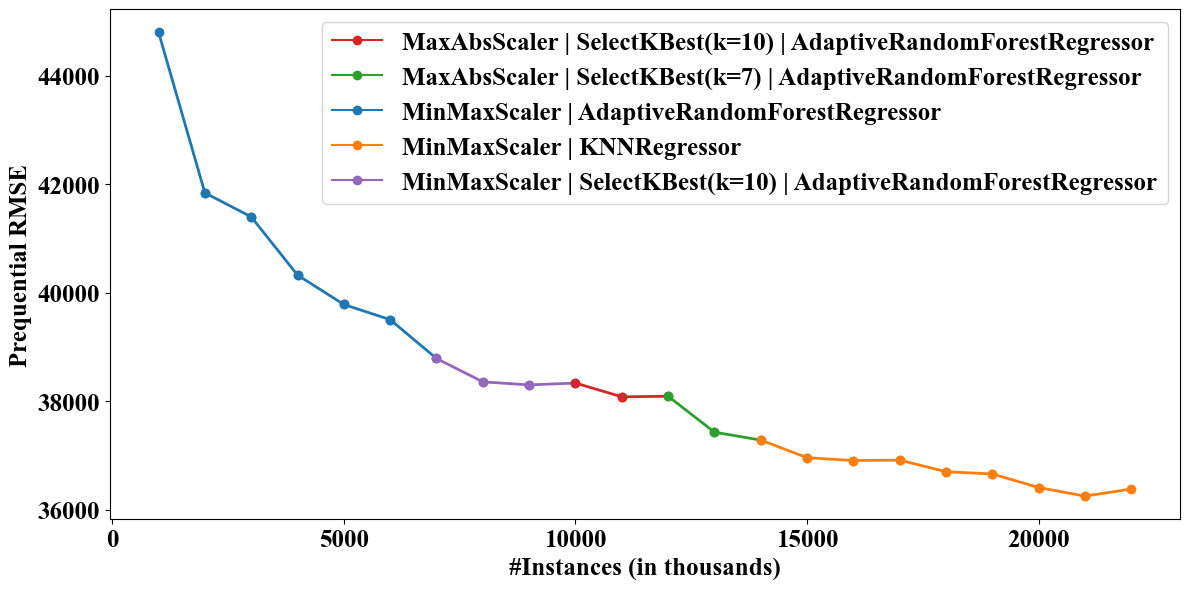

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Data points
x = dp_track #[val for i, val in enumerate(dp_track) if i%1000==0][1:]

# Algorithms 
algorithms = algo_track#[val for i, val in enumerate(algo_track) if i%1000==0][1:]#algo_track

# Scores
y = score_track#[val for i, val in enumerate(score_track) if i%1000==0][1:]#score_track

# Get unique algorithms
unique_algorithms = set(algorithms)

colors = ['#d62728', '#2ca02c', '#1f77b4', '#ff7f0e', '#9467bd',
'#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
'#4c78bf', '#f2bc49', '#67da91']
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--',
'-.', ':', '-']

# Generate color map
color_map = {}
for i,algo in enumerate(unique_algorithms):
    color_map[algo] = colors[i]
    
# Plot    
fig, ax = plt.subplots(figsize = (12, 6))

for i in range(len(x)):
    if i == 0:
        ax.plot(x[i], y[i], color=color_map[algorithms[i]]) 
    else:
        ax.plot([x[i-1], x[i]], [y[i-1], y[i]], color=color_map[algorithms[i]],linewidth=2.0,marker='o')

# Create legend    
handles = [plt.Line2D([0,1],[0,1], color=color_map[algo],marker='o') for algo in unique_algorithms] 
#ax.legend(handles, unique_algorithms,fontsize=8, ncol=7, loc='upper center', bbox_to_anchor=(0.5, 1.07))
ax.legend(handles, unique_algorithms,fontsize=18)
#plt.grid(True, linestyle='--', alpha=0.7)
        
ax.set_xlabel('#Instances (in thousands)',fontsize=18)
ax.set_ylabel('Prequential RMSE',fontsize=18)
#ax.set_title(db_name,fontsize=14,y=1.06)

plt.tight_layout()
plt.savefig(f'CHARTS/{file_name}.png', dpi=300)
       
plt.show()

In [40]:
file_name = 'pred_vs_true_line_plot_' + dataset_name
file_name

'pred_vs_true_line_plot_bike'

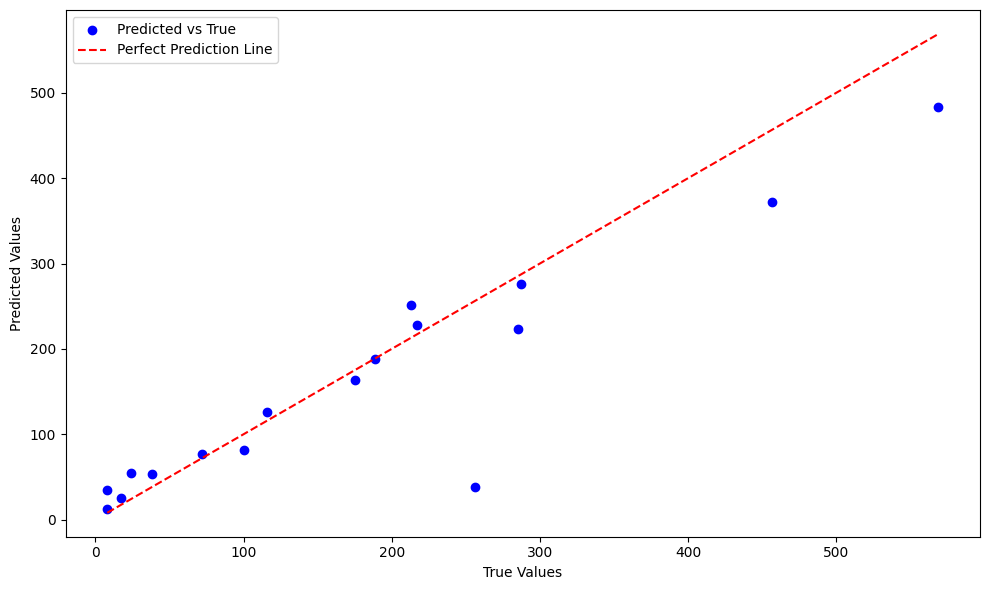

In [41]:
import matplotlib.pyplot as plt

# Sample data
y_true = [val for i, val in enumerate(df.y_true) if i%1000==0][1:] 
y_pred = [val for i, val in enumerate(df.y_pred) if i%1000==0][1:] 

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, color='blue', label='Predicted vs True')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Perfect Prediction Line')

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
#plt.title('True Values vs Predicted Values')
plt.legend()

plt.tight_layout()
plt.savefig(f'CHARTS/{file_name}.png', dpi=300)

# Show plot
#plt.grid(True)
plt.show()

In [42]:
file_name = 'Auto_Budgeting_' + dataset_name
file_name

'Auto_Budgeting_bike'

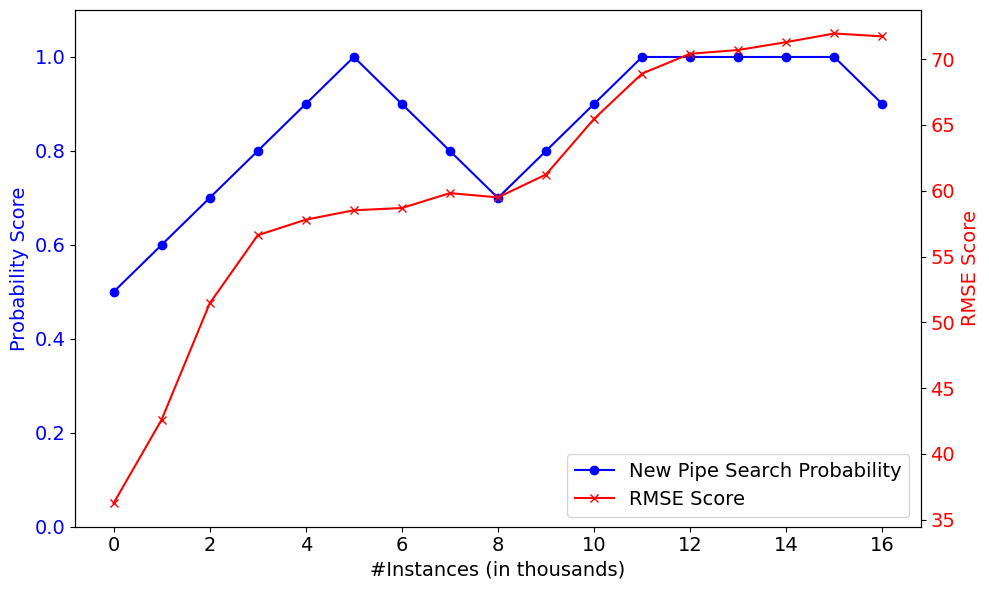

In [43]:
import matplotlib.pyplot as plt

# Sample data
probability_scores = [val for i, val in enumerate(df.search_probablity) if i%1000==0][1:]
rmse_score  = [val for i, val in enumerate(df['root mean squared error']) if i%1000==0][1:]
x_values = range(len(probability_scores))  # X values representing the indices of the scores

# Create a line chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot probability scores on the primary y-axis
ax1.plot(x_values, probability_scores, marker='o', linestyle='-', color='b', label='New Pipe Search Probability')
ax1.set_xlabel('#Instances (in thousands)', fontsize=14)
ax1.set_ylabel('Probability Score', fontsize=14, color='b')
ax1.set_ylim(0, 1.1)
ax1.tick_params(axis='y', labelcolor='b', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Create a secondary y-axis for RMSE scores
ax2 = ax1.twinx()
ax2.plot(x_values, rmse_score, marker='x', linestyle='-', color='r', label='RMSE Score')
ax2.set_ylabel('RMSE Score', fontsize=14, color='r')
ax2.tick_params(axis='y', labelcolor='r', labelsize=14)

# Add legends
fig.legend(loc="upper left", bbox_to_anchor=(0.57,0.16), bbox_transform=ax1.transAxes, fontsize=14)

plt.tight_layout()
plt.savefig(f'CHARTS/{file_name}.png', dpi=300)

# Show the plot
plt.show()

In [5]:
import numpy as np

In [17]:
np.random.normal(0,1)

-1.2292387130105373

In [18]:
np.argmax([-2,-3])

0

In [19]:
np.random.binomial(10, 0.8)

6

In [32]:
def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = [np.math.exp(i) for i in x]
    sum_e_x = sum(e_x)
    return [i / sum_e_x for i in e_x]

In [21]:
def _pwhs(current_value, values_list):
    print(f"Current Value: {current_value}")
    print(f"Values List: {values_list}")
    
    current_index = values_list.index(current_value)
    lower_values_list = values_list[:current_index]
    upper_values_list = values_list[current_index+1:]
    print(f"Lower Values List: {lower_values_list}")
    print(f"Upper Values List: {upper_values_list}")
    
    if len(lower_values_list) == 0:
        lower_values_list = [current_value]
    
    if len(upper_values_list) == 0:
        upper_values_list = [current_value]
    
    lower_values = np.random.choice(lower_values_list)
    upper_values = np.random.choice(upper_values_list)
    print(f"Random Lower Value: {lower_values}, Random Upper Value: {upper_values}")
    
    # Calculate the negative distance from the current value to the lower and upper values
    distance_lower = -(current_value - lower_values)    
    distance_upper = -(upper_values - current_value)
    print(f"Distance Lower: {distance_lower}, Distance Upper: {distance_upper}")
    
    # create a probability distribution based on the distance
    prob = softmax([distance_lower,distance_upper])#[1/(distance_lower+1), 1/(distance_upper+1)]
    print(f"Probabilities: {prob}")
    
    nearby_option = np.random.choice([lower_values,upper_values], p=prob)
    
    print(f"New Value: {nearby_option}")

In [40]:
def _pwhs(current_value, values_list):
    
    current_value_index = values_list.index(current_value)
    print(f"Current Value Index: {current_value_index}")
    print(f"Current Value: {current_value}")
    print(f"Values List: {values_list}")
    
    #calculate a negative distance from the current value to the all other values from the list
    distances = [abs(current_value - value) for value in values_list]
    print(f"Distances: {distances}")

    transformed_distances = [1 / (dist + 1) for dist in distances]
    
    #create a probability distribution based on the distance
    prob = softmax(transformed_distances)
    print(f"Probabilities: {prob}")
    
    #select a new value based on the probability distribution
    new_value = np.random.choice(values_list, p=prob)
    print(f"New Value: {new_value}")
    
    return new_value

In [1]:
def _pwhs(current_value, values_list):
    print(f"Current Value: {current_value}")
    print(f"Values List: {values_list}")
    
    try:

        # Calculate the distances from the current value
        distances = [abs(current_value - value) for value in values_list]
        
        print("Distances: ", distances)

        # Apply a non-linear transformation to the distances
        transformed_distances = [1 / (dist + 1) for dist in distances]
        print("Transformed Distances: ", transformed_distances)

        # Normalize the transformed distances to get probabilities
        prob = [dist / sum(transformed_distances) for dist in transformed_distances]
        print("Probabilities: ", prob)

        # Select a new value based on the probability distribution
        new_value = np.random.choice(values_list, p=prob)
        print(f"New Value: {new_value}")
    except:
        new_value = np.random.choice(values_list)
        print(f"Error: {new_value}")
    
    return new_value

In [82]:
from scipy.stats import gaussian_kde
def _pwhs(current_value, values_list):
    try:
        if isinstance(current_value, int) or isinstance(current_value, float):
            # Convert the list to a NumPy array
            values = np.asarray(values_list)

            #print(values)
            
            # Fit a Gaussian KDE to the values
            kde = gaussian_kde(values)
            
            # Calculate the probabilities for the values
            probabilities = kde.evaluate(values)

            #print(probabilities)
            
            # Normalize the probabilities to get a valid probability distribution
            probabilities /= probabilities.sum()

            #print(probabilities)
            
            # Select a new value based on the probability distribution
            new_value = np.random.choice(values, p=probabilities)
            return new_value
        else:
            # For other data types, use the existing _pwhs function
            return super()._pwhs(current_value, values_list)
    except Exception as e:
        print(f"Error in _pwhs: {e}")
        return np.random.choice(values_list)

In [43]:
current_value   = 10

In [44]:
values_list = [1,2,3,4,5,6,7,8,9,10]

In [54]:
_pwhs(current_value, values_list)

Current Value Index: 9
Current Value: 10
Values List: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Distances: [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Probabilities: [0.07917373417286576, 0.08005834774926694, 0.08117802679582094, 0.08264065472875294, 0.0846319006054133, 0.08750050848330332, 0.09198675548670186, 0.09998077704081539, 0.11811333204356576, 0.1947359628934939]
New Value: 7


7